In [3]:
from ambiance import Atmosphere
import numpy as np
import matplotlib.pyplot as plt
import sympy

from global_variables.solver import EquationSystem
from global_variables.registry import VariableRegistry, Variable

registry = VariableRegistry("aero_vars.yaml")

In [5]:
def velocity(M,h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.speed_of_sound[-1] * M / 0.3048
def rho_func(h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.density[-1] * 0.00194032

In [6]:
h = 3.6e4
plane_dict = {
     "S":9540.8654,
     "TSFC":.45,
     "h":h,
     "V":velocity(M=.839,h=h),
     "M":.9,
     "W_max":1.75e6,
     "W_pax":205,
     "We_Wmax":.46,
     "b":315,
     "e":0.9,
     "n_pax":1255,
     "rho_h":rho_func(h),
     "rho":rho_func(0),
     "C_Lmax":1.8,
     "C_D0":.02,
     "T_A0":4.2e5,
     "mu":.02,
}

In [7]:
outputs = {"S_TO", "R", "sigma_max"}
#outputs = {"R", "sigma_max"}

# Create solvers for each output
solvers = {
    output: EquationSystem(registry, {output})
    for output in outputs
}

# Get all unique inputs
all_inputs = set().union(*(solver.inputs for solver in solvers.values()))
print(f"Required inputs: {all_inputs}")
solvers

Required inputs: {'C_Lmax', 'mu', 'rho_h', 'n_pax', 'C_D0', 'rho', 'W_max', 'W_pax', 'b', 'We_Wmax', 'V', 'S_', 'e', 'TSFC', 'T_A0'}


{'S_TO': <global_variables.solver.EquationSystem at 0x71074afa34d0>,
 'R': <global_variables.solver.EquationSystem at 0x71079c2e4190>,
 'sigma_max': <global_variables.solver.EquationSystem at 0x71074af5bc50>}

In [8]:
Rf = solvers["R"].create_solver()
S_TOf = solvers["S_TO"].create_solver()

R_func = Rf["R"]
S_TO_func = S_TOf["S_TO"]


In [9]:
fuel_QRs = {
"JP":	43100.00,
"CH4":	50000.00,
"H2":	120000.00
}
def create_tsfcs(jp_tsfc):
    tsfcs = {}
    for fuel,qr in fuel_QRs.items():
        tsfcs[fuel] = jp_tsfc * fuel_QRs["JP"] / qr
    return tsfcs
create_tsfcs(0.5)

{'JP': 0.5, 'CH4': 0.431, 'H2': 0.17958333333333334}

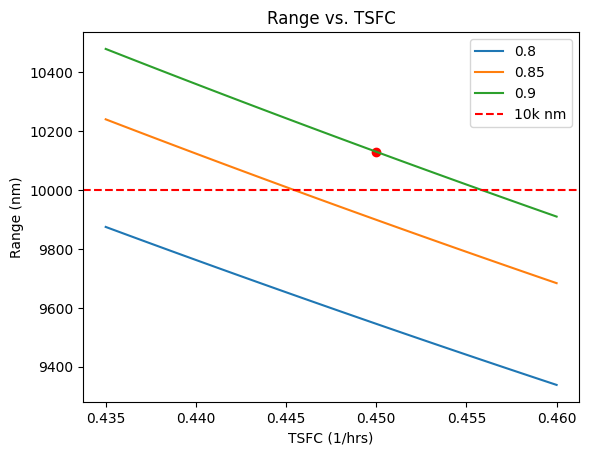

In [10]:
def R_vs_TSFC(cT,M):
  return R_func(
      C_D0=plane_dict['C_D0'],
      S_=plane_dict['S'],
      TSFC=cT/3600,
      V=velocity(M=M,h=plane_dict['h']),
      W_max=plane_dict['W_max'],
      W_pax=plane_dict['W_pax'],
      We_Wmax=plane_dict['We_Wmax'],
      b=plane_dict['b'],
      e=plane_dict['e'],
      n_pax=plane_dict['n_pax'],
      rho_h=plane_dict['rho_h']
  )
cTs = np.linspace(0.435,0.46,100)
Rs = {M : R_vs_TSFC(cTs,M) for M in [0.8,0.85,0.9]}

for M,R in Rs.items():
  plt.plot(cTs,R/6017,label=M)
plt.xlabel("TSFC (1/hrs)")
plt.ylabel("Range (nm)")
plt.title("Range vs. TSFC")
# horizontal line at 10k
plt.axhline(y=10e3, color='r', linestyle='--',label="10k nm")
# our point here
plt.scatter(plane_dict['TSFC'],R_vs_TSFC(plane_dict['TSFC'],plane_dict['M'])/6017,marker='o',c='r')
plt.legend()


#plt.show()
plt.savefig("range_vs_tsfc.png", dpi=300)

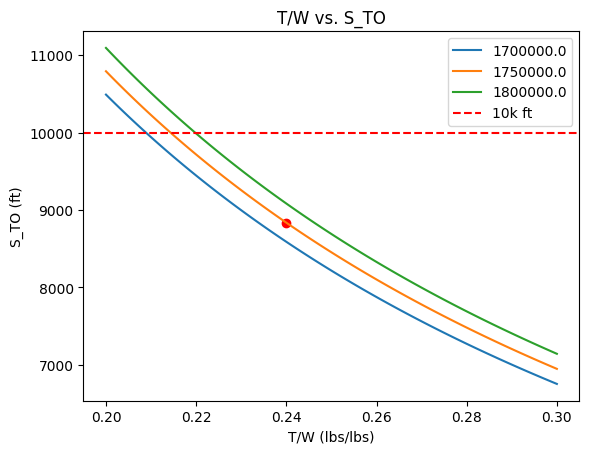

In [13]:
def TW_vs_S_TO(TW,max_weight=2e6):
    thrust = TW * max_weight
    return S_TO_func(
        C_D0=plane_dict['C_D0'],
        S_=plane_dict['S'],
        W_max=max_weight,
        b=plane_dict['b'],
        e=plane_dict['e'],
        rho=plane_dict['rho'],
        C_Lmax=plane_dict['C_Lmax'],
        T_A0=thrust,
        mu=plane_dict['mu'],
    )
             
TWs = np.linspace(0.2,0.3,100)
lines = {W : TW_vs_S_TO(TWs,W) for W in [1.7e6,1.75e6,1.8e6]}
#print(lines)
for W,TW in lines.items():
  plt.plot(TWs,TW,label=W)
plt.xlabel("T/W (lbs/lbs)")
plt.ylabel("S_TO (ft)")
plt.title("T/W vs. S_TO")
# horizontal line at 10k
plt.axhline(y=10e3, color='r', linestyle='--',label="10k ft")

# our point here
plt.scatter(plane_dict['T_A0']/plane_dict['W_max'],
            TW_vs_S_TO(plane_dict['T_A0']/plane_dict['W_max'],plane_dict['W_max']),
            marker='o',c='r')
plt.legend()


#plt.show()
plt.savefig("TW_vs_STO.png", dpi=300)

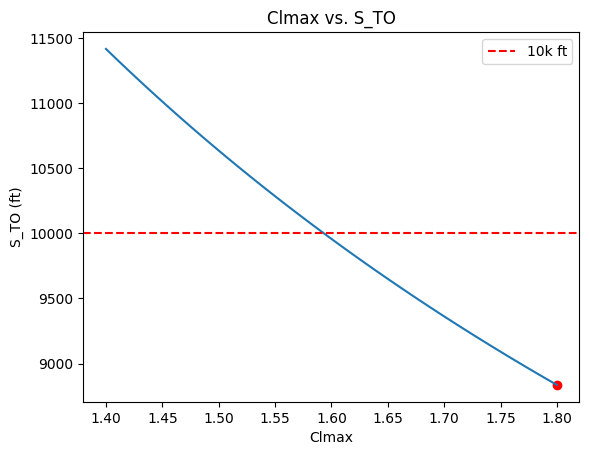

In [12]:
def Clmax_vs_S_TO(Clmax):
    return S_TO_func(
        C_D0=plane_dict['C_D0'],
        S_=plane_dict['S'],
        W_max=plane_dict['W_max'],
        b=plane_dict['b'],
        e=plane_dict['e'],
        rho=plane_dict['rho'],
        C_Lmax=Clmax,
        T_A0=plane_dict['T_A0'],
        mu=plane_dict['mu'],   
    )
                     
Clmaxs = np.linspace(1.4,1.8,100)
#lines = {W : Clmax_vs_S_TO(TWs,W) for W in [1.8e6,1.9e6,1.95e6,2e6]}
S_TOs = Clmax_vs_S_TO(Clmaxs)
#print(lines)
#for W,TW in lines.items():
plt.plot(Clmaxs,S_TOs)#,label=W)
plt.xlabel("Clmax")
plt.ylabel("S_TO (ft)")
plt.title("Clmax vs. S_TO")
# horizontal line at 10k
plt.axhline(y=10e3, color='r', linestyle='--',label="10k ft")

# our point here
plt.scatter(plane_dict['C_Lmax'],Clmax_vs_S_TO(plane_dict['C_Lmax']),marker='o',c='r')
plt.legend()


#plt.show()
plt.savefig("Clmax_vs_STO.png", dpi=300)